# `geomPointDensity()`

`geomPointDensity()` is like `geomPoint()`, but smarter in crowded spots. It plots each data point, and also colors that point based on how many other points are packed around it. Dense clusters get one color, sparse areas get another. So instead of just a scatterplot, you get a built-in heatmap of local point density, without needing a separate 2D density layer.

In [1]:
%useLatestDescriptors
%use dataframe
%use lets-plot(output="js,png")

In [2]:
LetsPlot.getInfo()

Lets-Plot Kotlin API v.4.12.0. Frontend: Notebook with dynamically loaded JS. Lets-Plot JS v.4.8.1.
Outputs: Web (HTML+JS), Static PNG (hidden)

## Prepare Data

In [3]:
// Helper functions

fun <T> DataFrame<T>.sample(n: Int, randomState: Long? = null): DataFrame<T> {
    val rng = randomState?.let { java.util.Random(it) } ?: java.util.Random()
    return this.rows().shuffled(rng).take(n).toDataFrame()
}

fun <T> DataFrame<T>.shape(): Pair<Int, Int> =
    Pair(this.rowsCount(), this.columnsCount())

In [4]:
val df = DataFrame.readCSV("https://raw.githubusercontent.com/JetBrains/lets-plot-docs/refs/heads/master/data/diamonds.csv")

val colorMapping = mapOf('D' to 7, 'E' to 6, 'F' to 5, 'G' to 4, 'H' to 3, 'I' to 2, 'J' to 1)
val dfWithMappedColor = df.add("color_mapped") { 
    colorMapping[it["color"]] ?: 0 
}.remove("color").rename("color_mapped" to "color")

val dfWithIdeal = dfWithMappedColor.add("is_ideal") {
    if (it["cut"] == "Ideal") "Quality: ideal" else "Quality: not ideal"
}

println(dfWithIdeal.shape())
dfWithIdeal.head()

(53940, 11)


carat,cut,clarity,depth,table,price,x,y,z,color,is_ideal
0.230000,Ideal,SI2,61.500000,55.000000,326,3.950000,3.980000,2.430000,6,Quality: ideal
0.210000,Premium,SI1,59.800000,61.000000,326,3.890000,3.840000,2.310000,6,Quality: not ideal
0.230000,Good,VS1,56.900000,65.000000,327,4.050000,4.070000,2.310000,6,Quality: not ideal
0.290000,Premium,VS2,62.400000,58.000000,334,4.200000,4.230000,2.630000,2,Quality: not ideal
0.310000,Good,SI2,63.300000,58.000000,335,4.340000,4.350000,2.750000,1,Quality: not ideal


In [5]:
val fairCutDf = dfWithIdeal
    .filter { it["cut"] == "Fair" }
    .remove("cut", "is_ideal")

println(fairCutDf.shape())
fairCutDf.head()

(1610, 9)


carat,clarity,depth,table,price,x,y,z,color
0.220000,VS2,65.100000,61.000000,337,3.870000,3.780000,2.490000,6
0.860000,SI2,55.100000,69.000000,2757,6.450000,6.330000,3.520000,6
0.960000,SI2,66.300000,62.000000,2759,6.270000,5.950000,4.070000,5
0.700000,VS2,64.500000,57.000000,2762,5.570000,5.530000,3.580000,5
0.700000,VS2,65.300000,55.000000,2762,5.630000,5.580000,3.660000,5


In [6]:
val data = dfWithIdeal.sample(10_000, randomState = 42).toMap()

## Default View

In [7]:
val p = letsPlot(fairCutDf.toMap()) { x = "carat"; y = "price" }


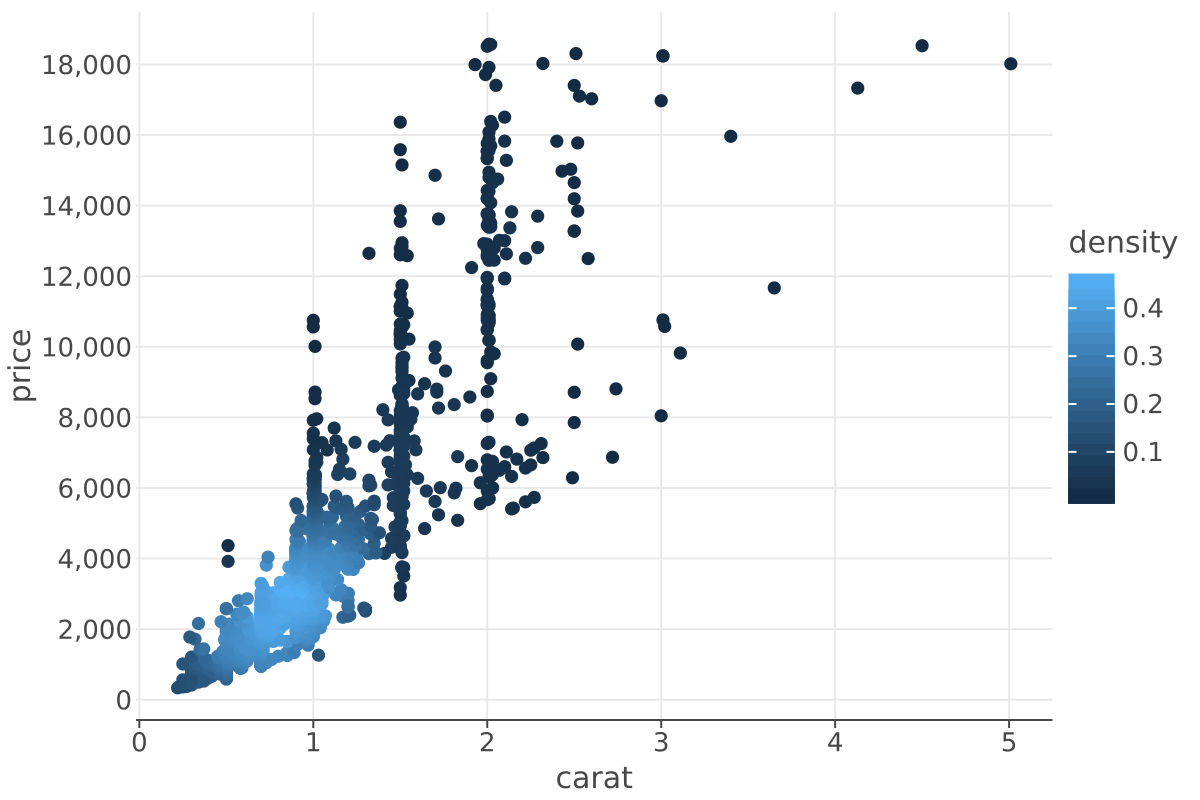

In [8]:
p + geomPointDensity()

## Parameters

### `adjust`


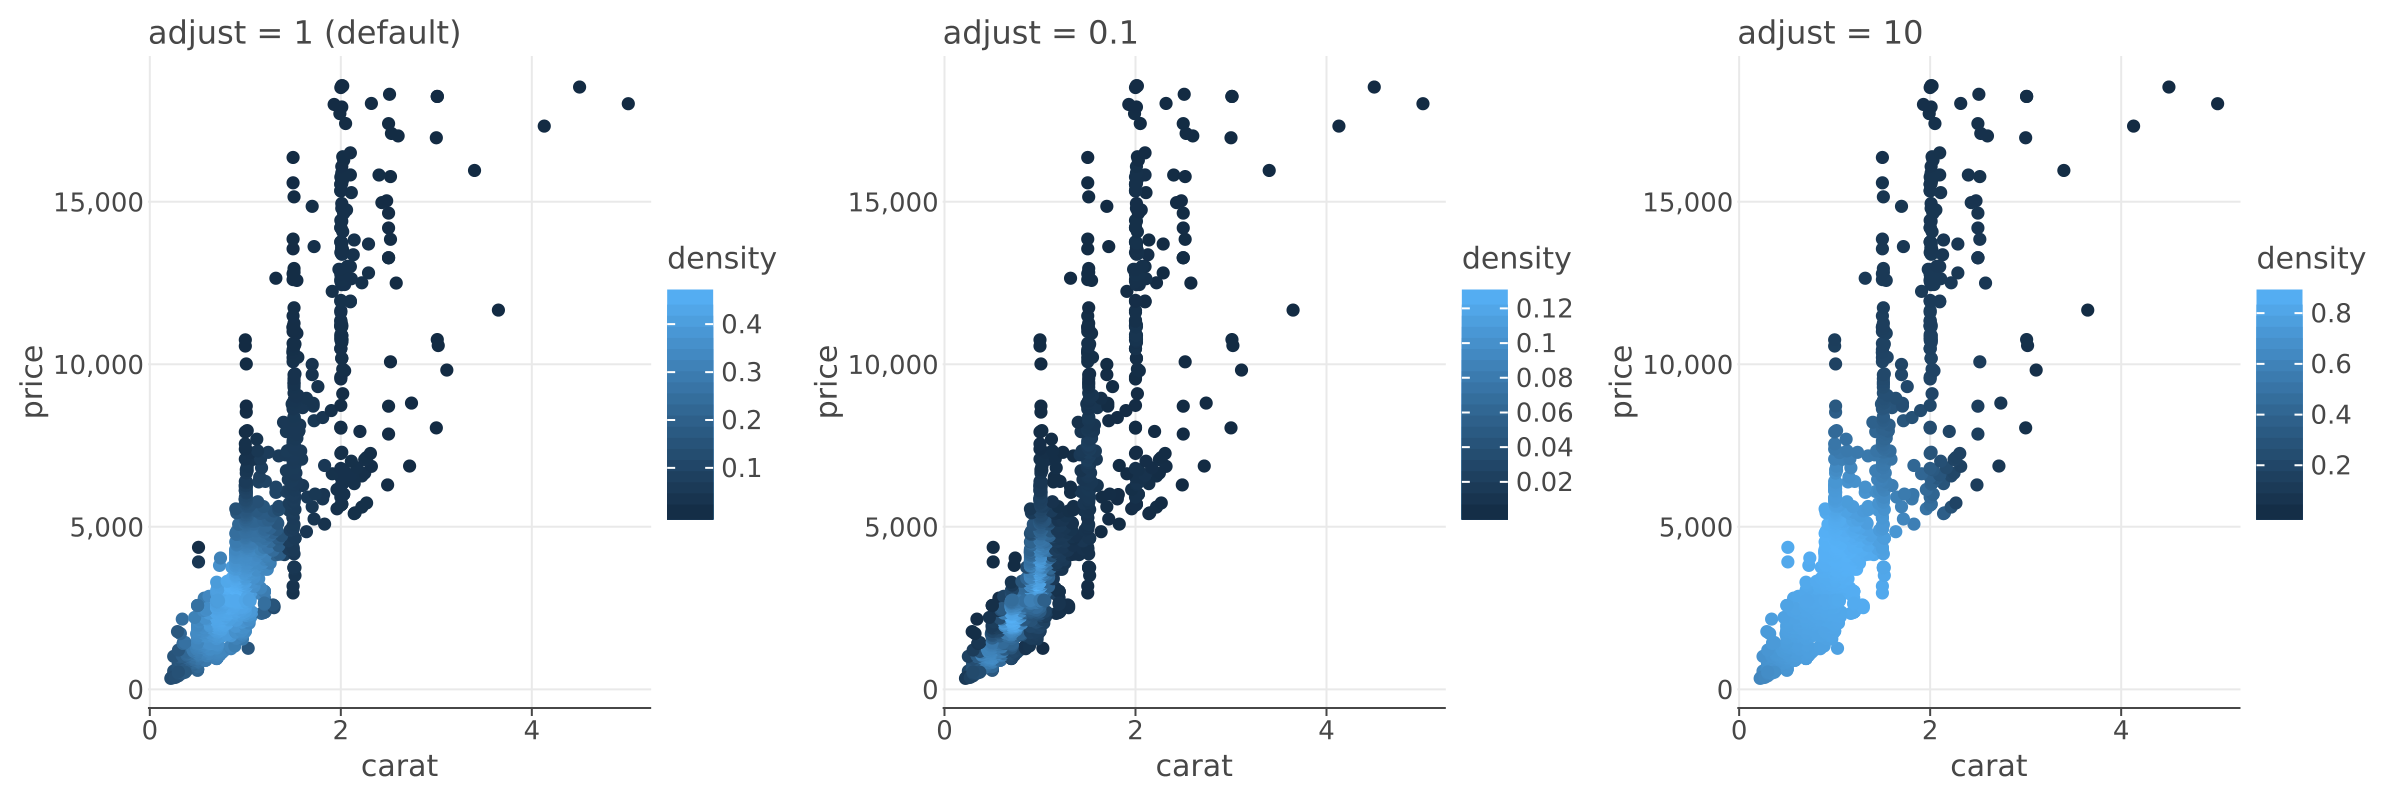

In [9]:
gggrid(listOf(
    p + geomPointDensity() + ggtitle("adjust = 1 (default)"),
    p + geomPointDensity(adjust = 0.1) + ggtitle("adjust = 0.1"),
    p + geomPointDensity(adjust = 10.0) + ggtitle("adjust = 10")
))

### `method`

Parameter `method` tells `geomPointDensity()` how to estimate "how crowded is it here?" around each point.

Here are the options:

- `"neighbours"` - for every point, it counts how many other points fall within some radius.

  Use when: you have a few thousand points (or less) and you want a very local, discrete crowding measure that treats each point individually.

- `"kde2d"` - builds a smooth 2D density surface (kernel density estimate) and then looks up that smooth density at each point.

  Use when: you have a ton of points (tens of thousands+), or you want something smoother / less noisy than direct neighbour counts.

- `"auto"` (default) - it chooses for you. For smaller datasets it behaves like `"neighbours"`; for larger datasets it switches to `"kde2d"`, because that scales better.

  Use when: you’re not sure about performance trade-offs and just want a sensible default.


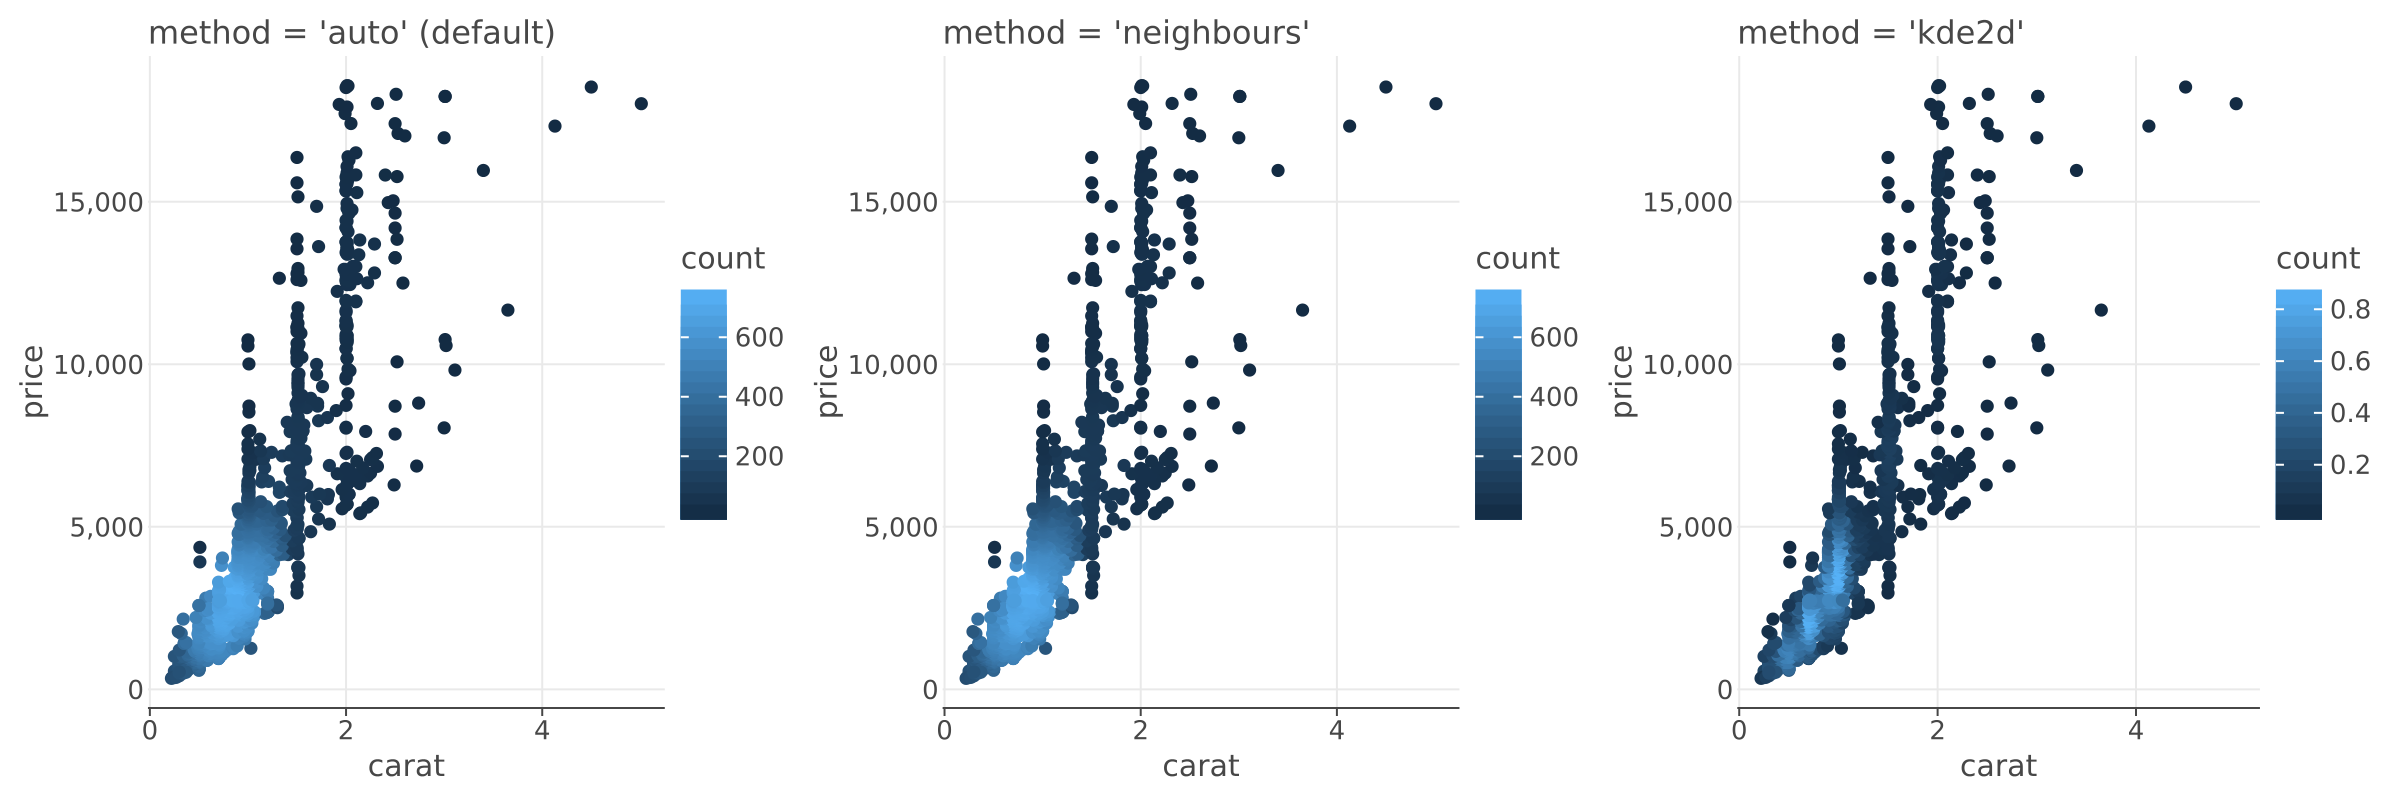

In [10]:
gggrid(listOf(
    p + geomPointDensity{ color = "..count.." } + ggtitle("method = 'auto' (default)"),
    p + geomPointDensity(method = "neighbours") { color = "..count.." } + ggtitle("method = 'neighbours'"),
    p + geomPointDensity(method = "kde2d") { color = "..count.." } + ggtitle("method = 'kde2d'")
))

Sometimes you may have additional reasons to explicitly specify the `method`:


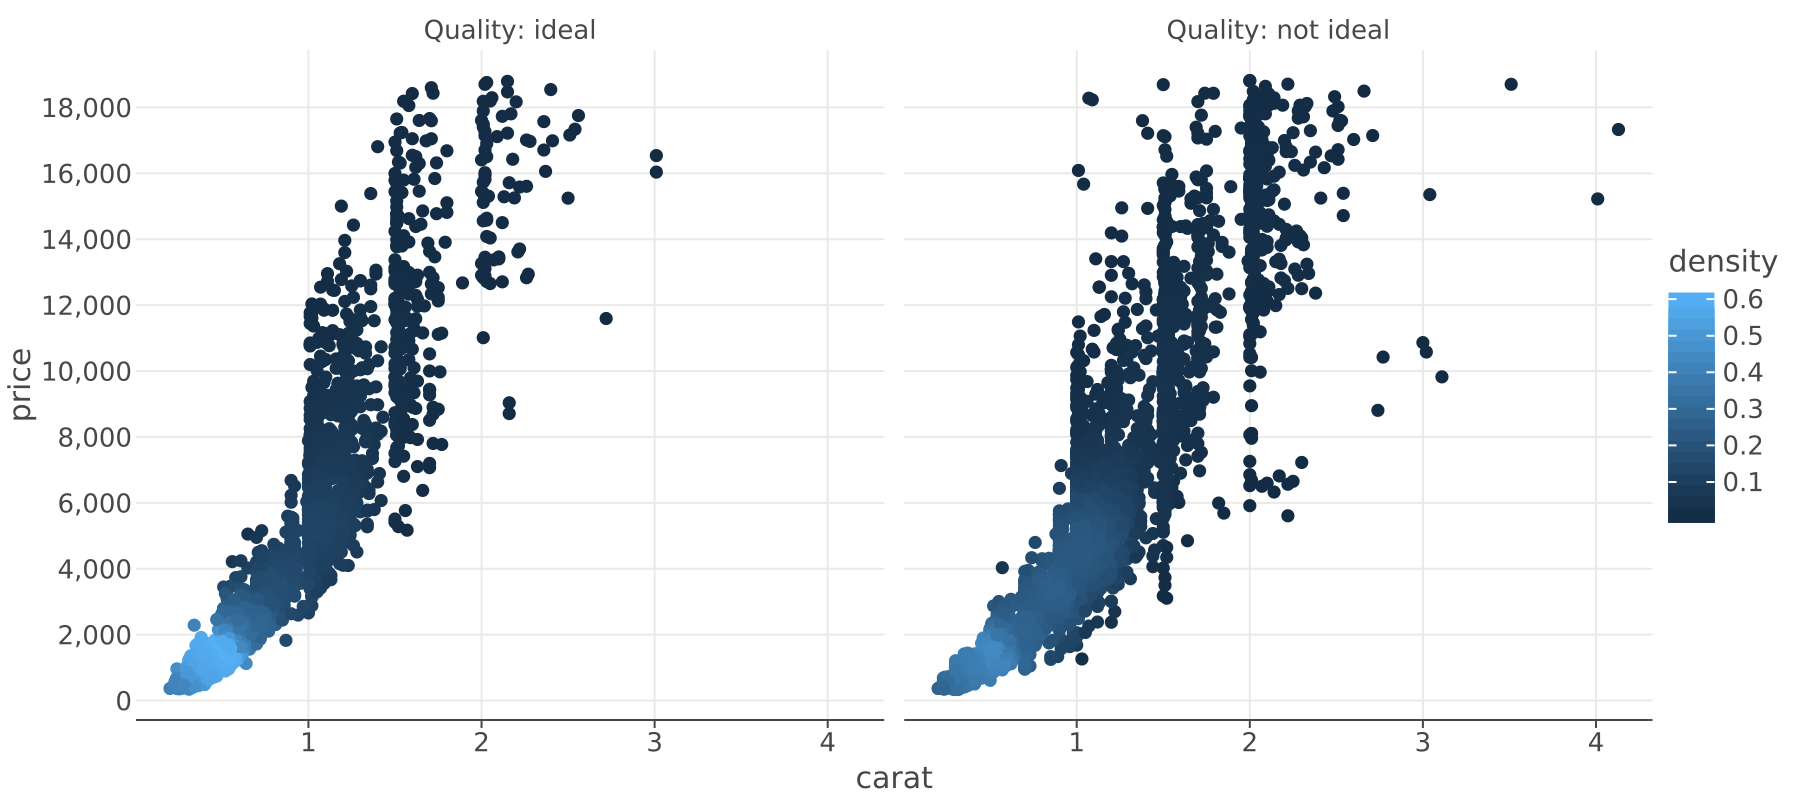

In [11]:
letsPlot(data) { x = "carat"; y = "price" } +
    geomPointDensity() + facetGrid(x = "is_ideal")

Although both subplots have the same distribution and a similar number of points, it is clear that the pictures are too different. This is because different methods were applied to different facets; the decision on which method to use is made independently for each data group.

This can easily be corrected by specifying the method explicitly:


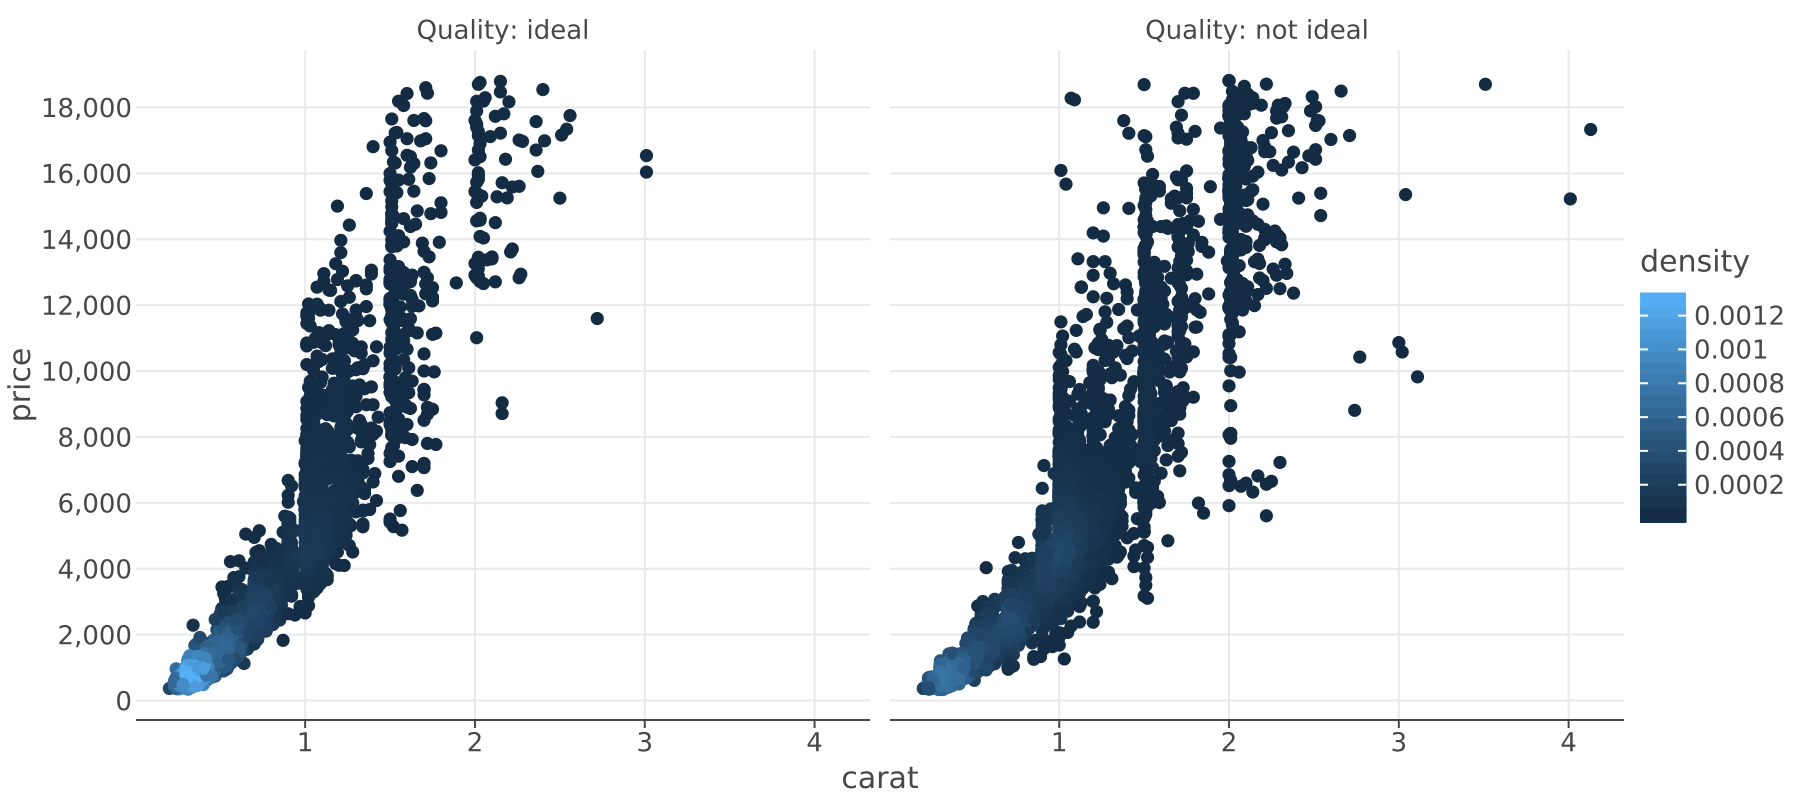

In [12]:
letsPlot(data) { x = "carat"; y = "price" } +
    geomPointDensity(method = "kde2d") + facetGrid(x = "is_ideal")

## Improved Appearance


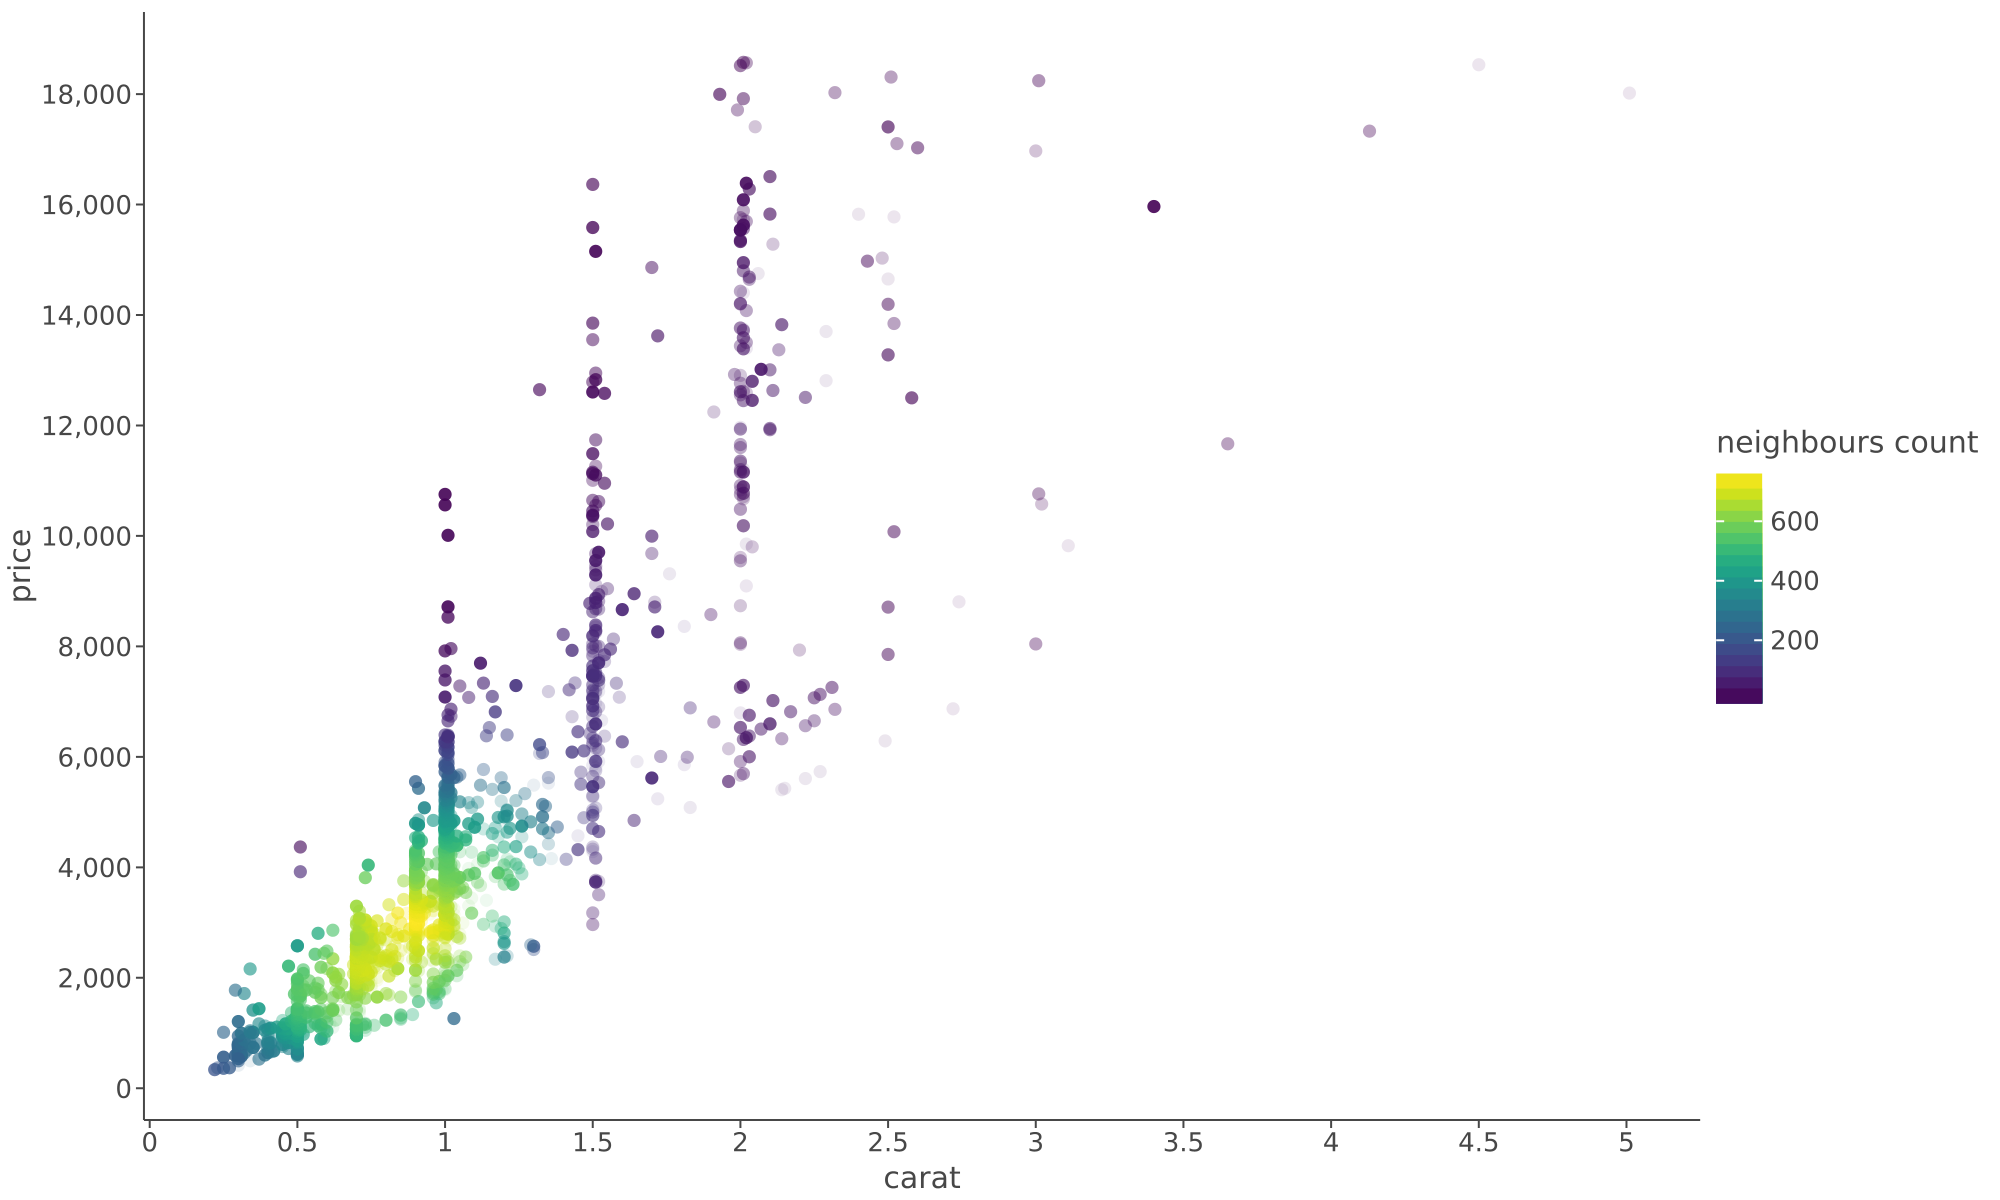

In [13]:
p +
    geomPointDensity(
        tooltips = layerTooltips()
            .line("neighbours count|@..count..")
            .line("diamond color\nfrom 1 (worst) to 7 (best)|@color")
            .line("clarity|@clarity")
    ) {
        alpha = "color"
        color = "..count.."
    } +
    scaleColorViridis(name = "neighbours count") +
    scaleAlpha(range = 0.1 to 0.9, guide = "none") +
    ggtb() +
    ggsize(1000, 600) +
    themeClassic()